In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-4298279c-7d3e-02d0-05de-5b4059c2c28e)


In [3]:
import os
os.chdir("/content/drive/MyDrive/ELI5")

# Argument Parser for t-sne trainer

In [4]:
from single_group_sw_tsne import *

In [19]:
class ArgumentsTSN():
  def __init__(self):
    self.data = "data/wiki/30k/wiki30k_reps.dat"
    self.cuda = 1  # if use cuda accelarate
    self.input_dim = 128  # input dimension
    self.output_dim = 64  # output dimension
    self.initial_momentum = 0.5   # initial momentum
    self.initial_iter = 10 # number of beginning interations to apply intial_momentum 
    self.early_exag = 20  # number of beginning interations to apply P value exaggeration
    self.final_momentum = 0.8  # final momentum
    self.exag_factor = 4.  # exag factor for P value for first early_exag iterations
    self.max_iter = 300    # maximum iteration

    self.init_method = "pca"   # pca / random initialization of reduced embedding

    self.window_size = 5000   # window size for each tsne computation
    self.jump_size = 1500    # (window - overlap size) for each tsne computation")
    self.perplexity = 30.0    
    self.n = 29727    # number of data points
    self.eta = 500
    self.min_gain = 0.01
    self.fuse_prob = 0.5  # fuse quesitons into docs for reducing
    self.ques_len = 20

opt = ArgumentsTSN()

# wiki30k reduce to 64D, without fusing Questions

In [6]:
data = opt.data
jump_size = opt.jump_size
max_iter = opt.max_iter
N = opt.n
window_size = opt.window_size

In [7]:
 # @TODO, no sure if this tensor is too large? Probably we need to use CPU first
X = np.memmap(opt.data, dtype='float32', mode='r', shape=(opt.n, opt.input_dim))
X = torch.Tensor(X)
#X = torch.randn([29727, 128])
'''
with open (opt.questions, "rb") as f:
  Q = np.load(f)
Q = torch.tensor(Q)
assert(X.shape[1] == Q.shape[1])
'''

assert(X.shape[0] == N)
print(X.shape)

KeyboardInterrupt: ignored

In [ ]:
Y = torch.zeros((N, opt.output_dim))
b_s = (N - window_size) // jump_size + 2
print(f"Batches to run: {b_s}")

In [ ]:
cur_Y = None
loss = []
batch_first_loss = []

In [ ]:
with torch.no_grad():
  for batch_idx in tqdm(range(b_s), total=b_s, position=0, leave=True):
    start = batch_idx * jump_size
    end = min(start + window_size, opt.n)
    print(start, end)

    cur_Y, cur_loss = tsne(X[start:end], max_iter=max_iter, window_size=min(window_size, end-start), jump_size=jump_size, prev_feat=cur_Y)
    batch_first_loss.append(cur_loss[0])
    loss.extend(cur_loss)
    Y[start:end] = cur_Y
    if end == opt.n: break

In [ ]:
print(Y.shape)
path = f"out/ws_{window_size}_js_{jump_size}_init_{opt.init_method}"
# save output
torch.save(Y, f"{path}.pt")
torch.save(torch.tensor(loss), f"{path}_loss.pt")
torch.save(torch.tensor(batch_first_loss), f"{path}_batch_first_loss.pt")

#Analysis for randomly initialized loss.

In [ ]:
import matplotlib.pyplot as plt
x_axis = np.arange(0, len(loss))
print(x_axis)
plt.plot(x_axis, np.array(loss))
plt.show()

In [ ]:
plt.close()

In [ ]:
x_h_axis = np.arange(0, len(batch_first_loss))
plt.plot(x_h_axis, np.array(batch_first_loss))
plt.show()

In [ ]:
plt.close()

In [ ]:
ax=plt.subplot(111)
ax.plot(x_h_axis, batch_first_loss, color='r',linewidth=1.0)
ax.set_ylim(0,1e6)
plt.show()

In [ ]:
ax=plt.subplot(111)
ax.plot(x_axis, loss, color='r',linewidth=1.0)
ax.set_ylim(6e3,1e6)
plt.show()

Analysis for pca init loss

In [ ]:
pca_full_loss = torch.load('out/max_300/ws_5000_js_1500_init_pca_loss.pt').detach().cpu().numpy()

In [ ]:
ax=plt.subplot(111)
ax.plot(x_axis, pca_full_loss, color='r',linewidth=1.0)
ax.set_ylim(6e3,1e6)
plt.show()

In [ ]:
ax=plt.subplot(111)
ax.plot(x_axis, pca_full_loss, color='r',linewidth=1.0)
ax.set_ylim(6e2,1e5)
plt.show()

In [ ]:
plt.plot(x_axis, pca_full_loss)
plt.show()

In [ ]:
pca_head_loss = torch.load('out/max_300/ws_5000_js_1500_init_pca_batch_first_loss.pt').detach().cpu().numpy()

In [ ]:
plt.plot(x_h_axis, pca_head_loss)
plt.show()

In [ ]:
ax=plt.subplot(111)
ax.plot(x_h_axis, pca_head_loss, color='r',linewidth=1.0)
ax.set_ylim(1e4,1e5)
plt.show()

#Now we run dimension reducer for Question embedding


In [ ]:
opt_ques = ArgumentsTSN()

In [ ]:
opt_ques.init_method = "pca"
opt_ques.data = "data/Questions/20/q_20_reps.npy"
opt_ques.max_iter = 1000
opt_ques.n = 20

In [ ]:
data = opt_ques.data
jump_size = opt_ques.jump_size
max_iter = opt_ques.max_iter
N = opt_ques.n
window_size = opt_ques.window_size

In [ ]:
 # @TODO, no sure if this tensor is too large? Probably we need to use CPU first
with open(data, 'rb') as f:
  ques = np.load(data, allow_pickle=True)
print(len(ques))

In [ ]:
ques = torch.Tensor(ques)
print(ques.shape)

In [ ]:
with torch.no_grad():
  ques_reduce, ques_reduce_loss = tsne(ques, max_iter=max_iter, window_size=20, jump_size=0, prev_feat=None)

In [ ]:
path = f"out/ques20_init_{opt_ques.init_method}"
# save output
torch.save(ques_reduce, f"{path}.pt")
torch.save(torch.tensor(ques_reduce_loss), f"{path}_loss.pt")

#Jointly reduce question and wiki docs together (for consistency)


In [5]:
from mult_group_sw_tsne import *

In [14]:
def train(args, ques, ques_init_reps):
  b_s = (args.n - args.window_size) // args.jump_size + 2
  print(f"Batches to run: {b_s}")
  cur_Y = None
  docs = np.memmap(opt.data, dtype='float32', mode='r', shape=(args.n, args.input_dim))
  docs = torch.Tensor(docs)
  Y = torch.zeros((args.n, args.output_dim))
  assert(ques_init_reps.shape[0] == args.ques_len)
  loss = []
  prev_ques = ques_init_reps
  batch_first_loss = []
  with torch.no_grad():
    #for batch_idx in tqdm(range(b_s), total=b_s, position=0, leave=True):
    for batch_idx in range(b_s):
        start = batch_idx * args.jump_size
        end = min(start + args.window_size, args.n)
        cur_Y, cur_loss, fuse = tsne(docs[start:end], ques, q_len=args.ques_len, q_prev_feat=prev_ques, q_fuse_prob=args.fuse_prob, max_iter=args.max_iter, window_size=min(args.window_size, end-start), jump_size=args.jump_size, prev_feat=cur_Y, initial_momentum=0.5, final_momentum=0.8, eta=500, min_gain=0.01, tol=1e-5, initial_iter=10, early_exag=50, exag_factor=4)

        batch_first_loss.append(cur_loss[0])
        loss.extend(cur_loss)
        if fuse:
          Y[start:end] = cur_Y[args.ques_len:]
          prev_ques = cur_Y[:args.ques_len]
        else:
          Y[start:end] = cur_Y
          # prev_ques stays the same
        if end == opt.n: break

  print(Y.shape)
  return Y, prev_ques, loss, batch_first_loss


In [7]:
ques_reduce = torch.load("out/ques20_init_pca.pt")

In [9]:
print(ques_reduce.shape)

torch.Size([20, 64])


In [8]:
with open("/content/drive/MyDrive/ELI5/data/Questions/20/q_20_reps.npy", "rb") as f:
  ques = np.load(f)

In [9]:
ques = torch.Tensor(ques)
print(ques.shape)

torch.Size([20, 128])


In [15]:
joint_Y, joint_ques, joint_loss, joint_batch_first_loss = train(opt, ques, ques_reduce)

  0%|          | 0/300 [00:00<?, ?it/s]

Batches to run: 18
torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:07,  2.35it/s]

iteration 0, error 155125.96327261976, dis 844874.0367273802


 17%|█▋        | 51/300 [00:21<01:43,  2.40it/s]

iteration 50, error 36175.62013965198, dis 129604.46023432945


 34%|███▎      | 101/300 [00:42<01:24,  2.36it/s]

iteration 100, error 35675.38153919473, dis 104.95319815885159


 50%|█████     | 151/300 [01:03<01:01,  2.42it/s]

iteration 150, error 34801.02235526723, dis 3.730632960294315


 67%|██████▋   | 201/300 [01:24<00:41,  2.38it/s]

iteration 200, error 34666.66153353121, dis -66.19882719776069


 84%|████████▎ | 251/300 [01:45<00:20,  2.35it/s]

iteration 250, error 34481.82398567829, dis -30.131203820288647


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:00,  2.49it/s]

iteration 0, error 354720.2565072463, dis 645279.7434927537


 17%|█▋        | 51/300 [00:21<01:45,  2.35it/s]

iteration 50, error 78475.8744948559, dis 278661.9716099745


 34%|███▎      | 101/300 [00:42<01:25,  2.33it/s]

iteration 100, error 78664.86054210529, dis -14.87104104620812


 50%|█████     | 151/300 [01:03<01:03,  2.36it/s]

iteration 150, error 103414.20189800057, dis 211.19644064755994


 67%|██████▋   | 201/300 [01:24<00:41,  2.38it/s]

iteration 200, error 91229.81300341246, dis 396.2117739307432


 84%|████████▎ | 251/300 [01:46<00:20,  2.37it/s]

iteration 250, error 84231.56767634953, dis 31.060729324395652


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:06,  2.37it/s]

iteration 0, error 90298.65233013286, dis 909701.3476698671


 17%|█▋        | 51/300 [00:21<01:46,  2.33it/s]

iteration 50, error 19600.836413095225, dis 71168.91341940711


 34%|███▎      | 101/300 [00:42<01:23,  2.38it/s]

iteration 100, error 19670.38009009308, dis -4.521925706030743


 50%|█████     | 151/300 [01:03<01:02,  2.38it/s]

iteration 150, error 26231.702258192774, dis -19.928711285108875


 67%|██████▋   | 201/300 [01:25<00:42,  2.33it/s]

iteration 200, error 22940.98813238522, dis 82.8074610212243


 84%|████████▎ | 251/300 [01:46<00:20,  2.39it/s]

iteration 250, error 21310.006659824045, dis -4.391495402302098


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:07,  2.35it/s]

iteration 0, error 69390.9314124338, dis 930609.0685875663


 17%|█▋        | 51/300 [00:21<01:44,  2.38it/s]

iteration 50, error 14910.467014879145, dis 54469.49981898263


 34%|███▎      | 101/300 [00:42<01:24,  2.36it/s]

iteration 100, error 15060.146477229639, dis -33.9819101344292


 50%|█████     | 151/300 [01:04<01:02,  2.37it/s]

iteration 150, error 16412.229943561095, dis 60.59744209301789


 67%|██████▋   | 201/300 [01:25<00:41,  2.36it/s]

iteration 200, error 15480.904374114654, dis -0.9494825154397404


 84%|████████▎ | 251/300 [01:46<00:20,  2.41it/s]

iteration 250, error 15328.75132937075, dis -7.161431567377804


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:07,  2.34it/s]

iteration 0, error 101318.39238721928, dis 898681.6076127808


 17%|█▋        | 51/300 [00:21<01:46,  2.35it/s]

iteration 50, error 22052.042443497558, dis 79895.74175364964


 34%|███▎      | 101/300 [00:42<01:23,  2.37it/s]

iteration 100, error 23180.291371744734, dis -254.72895027208142


 50%|█████     | 151/300 [01:03<01:01,  2.40it/s]

iteration 150, error 25726.679144889593, dis 134.18104412203684


 67%|██████▋   | 201/300 [01:25<00:41,  2.40it/s]

iteration 200, error 23290.581617063977, dis -16.434076710072986


 84%|████████▎ | 251/300 [01:46<00:20,  2.35it/s]

iteration 250, error 22645.633673011263, dis 20.626602646381798


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:10,  2.29it/s]

iteration 0, error 62835.69276602765, dis 937164.3072339724


 17%|█▋        | 51/300 [00:21<01:44,  2.39it/s]

iteration 50, error 13962.445042317984, dis 50404.23199041569


 34%|███▎      | 101/300 [00:42<01:26,  2.29it/s]

iteration 100, error 13915.711970903307, dis -5.640008992035291


 50%|█████     | 151/300 [01:04<01:02,  2.39it/s]

iteration 150, error 13813.787535415548, dis -2.786325768185634


 67%|██████▋   | 201/300 [01:25<00:42,  2.32it/s]

iteration 200, error 13809.37166142186, dis -11.372396403125094


 84%|████████▎ | 251/300 [01:46<00:20,  2.36it/s]

iteration 250, error 13773.334489512985, dis 18.822849914497056


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:01,  2.46it/s]

iteration 0, error 133933.337019891, dis 866066.662980109


 17%|█▋        | 51/300 [00:21<01:45,  2.36it/s]

iteration 50, error 30921.59342786324, dis 110287.197473385


 34%|███▎      | 101/300 [00:42<01:24,  2.36it/s]

iteration 100, error 29690.83543719205, dis 29.536862102995656


 50%|█████     | 151/300 [01:03<01:04,  2.30it/s]

iteration 150, error 29664.385216112292, dis 17.568680000265886


 67%|██████▋   | 201/300 [01:24<00:41,  2.38it/s]

iteration 200, error 29648.267046519257, dis 9.55822394214556


 84%|████████▎ | 251/300 [01:45<00:20,  2.42it/s]

iteration 250, error 29627.48271689551, dis 84.0284995938564


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:04,  2.40it/s]

iteration 0, error 699128.1908740302, dis 300871.80912596977


 17%|█▋        | 51/300 [00:21<01:45,  2.37it/s]

iteration 50, error 155229.1924334739, dis 546405.9046049347


 34%|███▎      | 101/300 [00:42<01:22,  2.41it/s]

iteration 100, error 157480.707730948, dis -259.06489144518855


 50%|█████     | 151/300 [01:03<01:01,  2.42it/s]

iteration 150, error 179836.97731437325, dis 466.9479233107413


 67%|██████▋   | 201/300 [01:24<00:41,  2.36it/s]

iteration 200, error 162942.80554313786, dis 77.06583501488785


 84%|████████▎ | 251/300 [01:45<00:20,  2.36it/s]

iteration 250, error 159218.60620940218, dis 20.51094991530408


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:09,  2.31it/s]

iteration 0, error 41452.16433796571, dis 958547.8356620343


 17%|█▋        | 51/300 [00:21<01:45,  2.36it/s]

iteration 50, error 9149.261890451124, dis 33738.90088373199


 34%|███▎      | 101/300 [00:42<01:22,  2.42it/s]

iteration 100, error 9049.352410723817, dis 3.3886190195698873


 50%|█████     | 151/300 [01:03<01:02,  2.37it/s]

iteration 150, error 9028.4740266565, dis 31.772616996111537


 67%|██████▋   | 201/300 [01:24<00:41,  2.38it/s]

iteration 200, error 9017.086733698363, dis 23.994153963743884


 84%|████████▎ | 251/300 [01:45<00:20,  2.39it/s]

iteration 250, error 9029.82532922411, dis 18.484360522597854


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:04,  2.41it/s]

iteration 0, error 26520.520483007636, dis 973479.4795169923


 17%|█▋        | 51/300 [00:21<01:45,  2.35it/s]

iteration 50, error 5713.8158164595125, dis 21241.80845964843


 34%|███▎      | 101/300 [00:42<01:24,  2.35it/s]

iteration 100, error 5776.545042251253, dis -13.67559672673815


 50%|█████     | 151/300 [01:03<01:05,  2.28it/s]

iteration 150, error 5756.2286286966355, dis 4.9946534965311


 67%|██████▋   | 201/300 [01:25<00:43,  2.30it/s]

iteration 200, error 5751.466494463934, dis 21.320986492140037


 84%|████████▎ | 251/300 [01:46<00:21,  2.30it/s]

iteration 250, error 5746.432115990907, dis 9.921090548405118


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:07,  2.35it/s]

iteration 0, error 128119.39827223799, dis 871880.601727762


 17%|█▋        | 51/300 [00:21<01:43,  2.40it/s]

iteration 50, error 27843.005630659627, dis 100548.06832041587


 34%|███▎      | 101/300 [00:42<01:24,  2.37it/s]

iteration 100, error 27974.13986455216, dis -10.932731953344046


 50%|█████     | 151/300 [01:03<01:04,  2.32it/s]

iteration 150, error 31406.907855515547, dis 158.44921608902223


 67%|██████▋   | 201/300 [01:24<00:41,  2.41it/s]

iteration 200, error 28934.22807953979, dis 48.67499698867323


 84%|████████▎ | 251/300 [01:45<00:20,  2.38it/s]

iteration 250, error 28515.50602627714, dis 21.58848897496864


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:05,  2.38it/s]

iteration 0, error 35275.857075333406, dis 964724.1429246666


 17%|█▋        | 51/300 [00:21<01:44,  2.37it/s]

iteration 50, error 8043.09219991701, dis 28864.739582251306


 34%|███▎      | 101/300 [00:43<01:27,  2.28it/s]

iteration 100, error 8348.90339403208, dis 43.055116241223004


 50%|█████     | 151/300 [01:04<01:01,  2.41it/s]

iteration 150, error 7700.900994654896, dis 4.298880827798712


 67%|██████▋   | 201/300 [01:25<00:42,  2.35it/s]

iteration 200, error 7673.3833799116055, dis 13.140377528528916


 84%|████████▎ | 251/300 [01:46<00:20,  2.40it/s]

iteration 250, error 7665.706154469315, dis 18.289118485516155


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:07,  2.35it/s]

iteration 0, error 103607.2549801089, dis 896392.7450198911


 17%|█▋        | 51/300 [00:21<01:46,  2.35it/s]

iteration 50, error 22437.188322321363, dis 81326.27065426775


 34%|███▎      | 101/300 [00:42<01:23,  2.40it/s]

iteration 100, error 26036.359042781765, dis -919.9279597939021


 50%|█████     | 151/300 [01:03<01:02,  2.39it/s]

iteration 150, error 26705.976408960974, dis 8.697836008366721


 67%|██████▋   | 201/300 [01:24<00:41,  2.38it/s]

iteration 200, error 23866.147991426256, dis 12.312446864383674


 84%|████████▎ | 251/300 [01:45<00:20,  2.40it/s]

iteration 250, error 23218.381610643453, dis 29.448216829547164


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:02,  2.44it/s]

iteration 0, error 73259.23276382322, dis 926740.7672361768


 17%|█▋        | 51/300 [00:20<01:45,  2.37it/s]

iteration 50, error 16062.397740736702, dis 58312.44844503392


 34%|███▎      | 101/300 [00:41<01:22,  2.42it/s]

iteration 100, error 16138.978369814266, dis 3.357039298125528


 50%|█████     | 151/300 [01:02<01:03,  2.36it/s]

iteration 150, error 16091.020258432096, dis 9.703644149178217


 67%|██████▋   | 201/300 [01:23<00:40,  2.42it/s]

iteration 200, error 16124.767414860602, dis -14.05221367697959


 84%|████████▎ | 251/300 [01:44<00:20,  2.43it/s]

iteration 250, error 16105.31125016638, dis 15.010215832751783


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:00,  2.48it/s]

iteration 0, error 278454.14238732844, dis 721545.8576126716


 17%|█▋        | 51/300 [00:20<01:42,  2.43it/s]

iteration 50, error 63559.18968725718, dis 219447.97550738847


 34%|███▎      | 101/300 [00:41<01:20,  2.47it/s]

iteration 100, error 62571.42780675282, dis 183.95172569110582


 50%|█████     | 151/300 [01:02<01:01,  2.44it/s]

iteration 150, error 62227.90237723477, dis -81.72316144611978


 67%|██████▋   | 201/300 [01:23<00:40,  2.46it/s]

iteration 200, error 62067.96920884006, dis 84.81395077865454


 84%|████████▎ | 251/300 [01:43<00:20,  2.42it/s]

iteration 250, error 62140.57643546832, dis -18.56225642784557


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<01:59,  2.50it/s]

iteration 0, error 146899.05185591293, dis 853100.9481440871


 17%|█▋        | 51/300 [00:21<01:41,  2.46it/s]

iteration 50, error 32138.844341064334, dis 115691.57666341658


 34%|███▎      | 101/300 [00:41<01:22,  2.42it/s]

iteration 100, error 32241.232027755977, dis -7.11581408274651


 50%|█████     | 151/300 [01:03<01:02,  2.37it/s]

iteration 150, error 42987.78892582009, dis 96.49918761100707


 67%|██████▋   | 201/300 [01:25<00:42,  2.33it/s]

iteration 200, error 38056.18502559417, dis 176.4242549184928


 84%|████████▎ | 251/300 [01:46<00:20,  2.34it/s]

iteration 250, error 35039.077790560084, dis 54.38148664248001


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:10,  2.28it/s]

iteration 0, error 137960.8283551003, dis 862039.1716448998


 17%|█▋        | 51/300 [00:22<01:49,  2.27it/s]

iteration 50, error 36669.216161484845, dis 128159.83635565494


 34%|███▎      | 101/300 [00:43<01:25,  2.32it/s]

iteration 100, error 33089.62126704345, dis 101.43494720911258


 50%|█████     | 151/300 [01:05<01:04,  2.30it/s]

iteration 150, error 31402.555259491688, dis 4.368423791544046


 67%|██████▋   | 201/300 [01:27<00:42,  2.31it/s]

iteration 200, error 31031.346847237586, dis -56.187440249941574


 84%|████████▎ | 251/300 [01:49<00:21,  2.27it/s]

iteration 250, error 30822.58093899474, dis -12.575702703048592


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([4247, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<01:48,  2.74it/s]

iteration 0, error 757938.6680448977, dis 242061.33195510227


 17%|█▋        | 51/300 [00:18<01:28,  2.81it/s]

iteration 50, error 185460.73517297214, dis 623541.754750968


 34%|███▎      | 101/300 [00:36<01:10,  2.81it/s]

iteration 100, error 190945.57166672195, dis 219.56250381006976


 50%|█████     | 151/300 [00:54<00:54,  2.75it/s]

iteration 150, error 182405.3014681166, dis -41.643080463429214


 67%|██████▋   | 201/300 [01:12<00:36,  2.73it/s]

iteration 200, error 177564.24439201993, dis -398.54728590877494


 84%|████████▎ | 251/300 [01:30<00:17,  2.78it/s]

iteration 250, error 175000.835469281, dis -50.30551919521531


100%|██████████| 300/300 [01:47<00:00,  2.78it/s]

torch.Size([29727, 64])


In [18]:
path = f"joint_prob_{opt.fuse_prob}_ws_{opt.window_size}_js_{opt.jump_size}_init_{opt.init_method}"
    # save output
torch.save(joint_Y, f"{path}.pt")
torch.save(joint_ques, f"{path}_question_rep.pt")
torch.save(torch.tensor(joint_loss), f"{path}_loss.pt")
torch.save(torch.tensor(joint_batch_first_loss), f"{path}_batch_first_loss.pt")

In [20]:
joint_Y, joint_ques, joint_loss, joint_batch_first_loss = train(opt, ques, ques_reduce)

  0%|          | 0/300 [00:00<?, ?it/s]

Batches to run: 18
torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:12,  2.26it/s]

iteration 0, error 35055.81030046245, dis 964944.1896995376


 17%|█▋        | 51/300 [00:22<01:47,  2.32it/s]

iteration 50, error 9202.873753658725, dis 32916.11261310939


 34%|███▎      | 101/300 [00:44<01:26,  2.31it/s]

iteration 100, error 7881.180533500811, dis 14.364610587270363


 50%|█████     | 151/300 [01:06<01:05,  2.28it/s]

iteration 150, error 7658.164624081887, dis 7.7934894430181885


 67%|██████▋   | 201/300 [01:27<00:43,  2.30it/s]

iteration 200, error 7638.88401052299, dis 5.4320263013460135


 84%|████████▎ | 251/300 [01:49<00:21,  2.30it/s]

iteration 250, error 7636.672307586097, dis -7.4457907450942


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:17,  2.17it/s]

iteration 0, error 51425.15593700593, dis 948574.8440629941


 17%|█▋        | 51/300 [00:22<01:48,  2.29it/s]

iteration 50, error 11007.291890568951, dis 40442.68034537926


 34%|███▎      | 101/300 [00:44<01:28,  2.26it/s]

iteration 100, error 11039.599655246033, dis -2.211362891281169


 50%|█████     | 151/300 [01:05<01:04,  2.32it/s]

iteration 150, error 12347.27082065097, dis 26.66295684990473


 67%|██████▋   | 201/300 [01:27<00:42,  2.32it/s]

iteration 200, error 11446.163393320974, dis 14.483444215777126


 84%|████████▎ | 251/300 [01:49<00:21,  2.32it/s]

iteration 250, error 11329.87166227065, dis -18.727664736203224


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:11,  2.27it/s]

iteration 0, error 358699.9055069868, dis 641300.0944930132


 17%|█▋        | 51/300 [00:21<01:44,  2.39it/s]

iteration 50, error 78957.76387767319, dis 280508.02234693064


 34%|███▎      | 101/300 [00:43<01:25,  2.32it/s]

iteration 100, error 86640.41864656557, dis 564.4107725254144


 50%|█████     | 151/300 [01:04<01:02,  2.38it/s]

iteration 150, error 80310.85619528109, dis -43.6900844656775


 67%|██████▋   | 201/300 [01:25<00:41,  2.39it/s]

iteration 200, error 80264.5127156396, dis -40.74892719008494


 84%|████████▎ | 251/300 [01:46<00:20,  2.37it/s]

iteration 250, error 80195.00897506901, dis -126.71661751437932


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:04,  2.41it/s]

iteration 0, error 95589.53308157076, dis 904410.4669184292


 17%|█▋        | 51/300 [00:21<01:45,  2.35it/s]

iteration 50, error 20988.370737445075, dis 76168.23808053251


 34%|███▎      | 101/300 [00:42<01:25,  2.33it/s]

iteration 100, error 21144.428008443174, dis 34.03280433238615


 50%|█████     | 151/300 [01:03<01:02,  2.39it/s]

iteration 150, error 21094.10703404026, dis 0.49840776810378884


 67%|██████▋   | 201/300 [01:25<00:41,  2.37it/s]

iteration 200, error 21072.529467589367, dis 3.446922676765098


 84%|████████▎ | 251/300 [01:46<00:21,  2.33it/s]

iteration 250, error 21107.51563925098, dis -1.1969319699965126


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:08,  2.32it/s]

iteration 0, error 129754.91592637936, dis 870245.0840736206


 17%|█▋        | 51/300 [00:21<01:44,  2.39it/s]

iteration 50, error 28178.017441257012, dis 101711.09766880487


 34%|███▎      | 101/300 [00:42<01:22,  2.40it/s]

iteration 100, error 29352.949571175952, dis 45.50139691671211


 50%|█████     | 151/300 [01:03<01:01,  2.42it/s]

iteration 150, error 28753.37152737247, dis -10.531862016836385


 67%|██████▋   | 201/300 [01:24<00:41,  2.38it/s]

iteration 200, error 28762.816507037005, dis 64.00887548827814


 84%|████████▎ | 251/300 [01:45<00:20,  2.38it/s]

iteration 250, error 28769.74961081821, dis -24.61097839586364


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:05,  2.39it/s]

iteration 0, error 202751.36352727556, dis 797248.6364727244


 17%|█▋        | 51/300 [00:21<01:43,  2.39it/s]

iteration 50, error 45322.50510331618, dis 161211.37268248634


 34%|███▎      | 101/300 [00:42<01:22,  2.41it/s]

iteration 100, error 45093.175755025644, dis -48.71848243055865


 50%|█████     | 151/300 [01:03<01:01,  2.43it/s]

iteration 150, error 45101.073646316036, dis -90.75363209677744


 67%|██████▋   | 201/300 [01:24<00:42,  2.35it/s]

iteration 200, error 45135.36341308092, dis -86.6340849130138


 84%|████████▎ | 251/300 [01:45<00:21,  2.33it/s]

iteration 250, error 45153.234966137476, dis -62.4427735771751


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:03,  2.41it/s]

iteration 0, error 219040.20645352296, dis 780959.7935464771


 17%|█▋        | 51/300 [00:21<01:44,  2.38it/s]

iteration 50, error 48110.47470459855, dis 172113.97306493667


 34%|███▎      | 101/300 [00:42<01:23,  2.39it/s]

iteration 100, error 48184.698132248304, dis -5.443202495531295


 50%|█████     | 151/300 [01:03<01:04,  2.32it/s]

iteration 150, error 60164.97715011312, dis -1718.3805275521008


 67%|██████▋   | 201/300 [01:24<00:41,  2.39it/s]

iteration 200, error 59654.26159501331, dis 106.88035163767927


 84%|████████▎ | 251/300 [01:45<00:20,  2.40it/s]

iteration 250, error 53372.965204064516, dis 61.293330652231816


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:05,  2.39it/s]

iteration 0, error 58745.01938514404, dis 941254.980614856


 17%|█▋        | 51/300 [00:21<01:44,  2.38it/s]

iteration 50, error 13435.324736089946, dis 48722.6038151952


 34%|███▎      | 101/300 [00:42<01:21,  2.43it/s]

iteration 100, error 13069.688999969203, dis -1.236305360969709


 50%|█████     | 151/300 [01:03<01:02,  2.38it/s]

iteration 150, error 12972.141277196093, dis -9.472362293032347


 67%|██████▋   | 201/300 [01:24<00:41,  2.40it/s]

iteration 200, error 12945.855871363694, dis -8.742248762859163


 84%|████████▎ | 251/300 [01:45<00:20,  2.39it/s]

iteration 250, error 12896.465414743949, dis 17.767904936217747


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:18,  2.16it/s]

iteration 0, error 396993.86767205526, dis 603006.1323279447


 17%|█▋        | 51/300 [00:21<01:43,  2.41it/s]

iteration 50, error 88094.06605879203, dis 311346.7850120347


 34%|███▎      | 101/300 [00:42<01:23,  2.40it/s]

iteration 100, error 89204.98553084946, dis -5.330087431430002


 50%|█████     | 151/300 [01:03<01:02,  2.40it/s]

iteration 150, error 88892.80106179952, dis 36.17541312277899


 67%|██████▋   | 201/300 [01:24<00:41,  2.40it/s]

iteration 200, error 88935.38938906879, dis -60.22935853002127


 84%|████████▎ | 251/300 [01:45<00:20,  2.39it/s]

iteration 250, error 88956.3595670276, dis 29.378558074851753


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:10,  2.29it/s]

iteration 0, error 168552.79425497644, dis 831447.2057450236


 17%|█▋        | 51/300 [00:21<01:44,  2.39it/s]

iteration 50, error 38776.79298314222, dis 139018.58859873397


 34%|███▎      | 101/300 [00:42<01:22,  2.40it/s]

iteration 100, error 37426.07982269985, dis -17.862583695845387


 50%|█████     | 151/300 [01:03<01:04,  2.32it/s]

iteration 150, error 37389.65846149245, dis -0.631042864129995


 67%|██████▋   | 201/300 [01:24<00:42,  2.36it/s]

iteration 200, error 37411.26364880308, dis 58.396923621381575


 84%|████████▎ | 251/300 [01:45<00:20,  2.38it/s]

iteration 250, error 37434.87718448257, dis 0.8764452077884926


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:05,  2.39it/s]

iteration 0, error 40393.87785438, dis 959606.12214562


 17%|█▋        | 51/300 [00:21<01:41,  2.45it/s]

iteration 50, error 8716.150538539983, dis 32724.412058938553


 34%|███▎      | 101/300 [00:41<01:20,  2.47it/s]

iteration 100, error 11694.990408750682, dis 55.732572964911014


 50%|█████     | 151/300 [01:02<01:02,  2.40it/s]

iteration 150, error 9946.814147177069, dis 16.568958832362114


 67%|██████▋   | 201/300 [01:22<00:40,  2.46it/s]

iteration 200, error 9320.290452875877, dis -21.40980343784213


 84%|████████▎ | 251/300 [01:43<00:19,  2.48it/s]

iteration 250, error 9075.63168273358, dis -10.315297433877276


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:00,  2.47it/s]

iteration 0, error 66188.14692416975, dis 933811.8530758303


 17%|█▋        | 51/300 [00:20<01:42,  2.43it/s]

iteration 50, error 14605.308822994517, dis 53176.15911661579


 34%|███▎      | 101/300 [00:41<01:20,  2.48it/s]

iteration 100, error 14600.20494343571, dis -19.7547621136182


 50%|█████     | 151/300 [01:01<01:00,  2.46it/s]

iteration 150, error 14530.06165278269, dis 18.606220018937165


 67%|██████▋   | 201/300 [01:21<00:40,  2.43it/s]

iteration 200, error 14520.149060721611, dis 0.1184029276973888


 84%|████████▎ | 251/300 [01:42<00:20,  2.44it/s]

iteration 250, error 14555.850862540601, dis -28.42529454498981


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<01:57,  2.55it/s]

iteration 0, error 65885.86683108046, dis 934114.1331689195


 17%|█▋        | 51/300 [00:20<01:41,  2.44it/s]

iteration 50, error 14412.259031448857, dis 52461.511067060965


 34%|███▎      | 101/300 [00:40<01:19,  2.49it/s]

iteration 100, error 14490.080490119479, dis -8.90038557825028


 50%|█████     | 151/300 [01:01<01:00,  2.46it/s]

iteration 150, error 14489.21039608499, dis -16.987922219988832


 67%|██████▋   | 201/300 [01:21<00:40,  2.47it/s]

iteration 200, error 14463.268168843522, dis -4.895850840193816


 84%|████████▎ | 251/300 [01:42<00:19,  2.45it/s]

iteration 250, error 14473.946880110569, dis -1.2364831664672238


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<01:58,  2.52it/s]

iteration 0, error 175273.7650709945, dis 824726.2349290055


 17%|█▋        | 51/300 [00:20<01:41,  2.46it/s]

iteration 50, error 43414.87877885854, dis 153628.380223129


 34%|███▎      | 101/300 [00:40<01:20,  2.48it/s]

iteration 100, error 41900.71246955065, dis 53.307880086489604


 50%|█████     | 151/300 [01:01<00:59,  2.48it/s]

iteration 150, error 40745.64066495097, dis 109.26352293456875


 67%|██████▋   | 201/300 [01:21<00:40,  2.46it/s]

iteration 200, error 39967.792083890454, dis 33.688077694583626


 84%|████████▎ | 251/300 [01:41<00:19,  2.49it/s]

iteration 250, error 39686.450124127085, dis 10.64364866638789


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5000, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<01:56,  2.56it/s]

iteration 0, error 61712.805935584634, dis 938287.1940644154


 17%|█▋        | 51/300 [00:20<01:40,  2.47it/s]

iteration 50, error 13636.045893503786, dis 49719.67490236627


 34%|███▎      | 101/300 [00:41<01:20,  2.48it/s]

iteration 100, error 13552.056733146183, dis -6.327566392872541


 50%|█████     | 151/300 [01:01<01:01,  2.44it/s]

iteration 150, error 13525.456710909628, dis 17.357948556207702


 67%|██████▋   | 201/300 [01:21<00:39,  2.51it/s]

iteration 200, error 13524.800530618435, dis 41.518625099763085


 84%|████████▎ | 251/300 [01:41<00:19,  2.45it/s]

iteration 250, error 13544.681492382288, dis 4.708566268784125


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:04,  2.41it/s]

iteration 0, error 35436.485900147316, dis 964563.5140998526


 17%|█▋        | 51/300 [00:20<01:41,  2.46it/s]

iteration 50, error 7795.178596365182, dis 29238.13780541311


 34%|███▎      | 101/300 [00:40<01:22,  2.42it/s]

iteration 100, error 7731.950837367116, dis 5.7838910686041345


 50%|█████     | 151/300 [01:01<01:01,  2.42it/s]

iteration 150, error 7718.462482884079, dis -3.914108157271585


 67%|██████▋   | 201/300 [01:21<00:40,  2.46it/s]

iteration 200, error 7727.378841382628, dis -16.531738814104756


 84%|████████▎ | 251/300 [01:41<00:19,  2.49it/s]

iteration 250, error 7739.544240105108, dis -23.232428620119208


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([5020, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<02:11,  2.27it/s]

iteration 0, error 78979.83888634687, dis 921020.1611136531


 17%|█▋        | 51/300 [00:20<01:41,  2.45it/s]

iteration 50, error 17017.396195920424, dis 61994.661214419284


 34%|███▎      | 101/300 [00:41<01:21,  2.44it/s]

iteration 100, error 19203.170688788137, dis 163.40272116271808


 50%|█████     | 151/300 [01:01<01:00,  2.48it/s]

iteration 150, error 17448.943582104745, dis 9.596025864237163


 67%|██████▋   | 201/300 [01:22<00:41,  2.41it/s]

iteration 200, error 17400.899779897933, dis -17.036228136887075


 84%|████████▎ | 251/300 [01:42<00:19,  2.48it/s]

iteration 250, error 17355.358215935907, dis 19.16731020707084


  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([4247, 128])
Preprocessing the data using PCA...


  0%|          | 1/300 [00:00<01:43,  2.89it/s]

iteration 0, error 264035.2424387032, dis 735964.7575612968


 17%|█▋        | 51/300 [00:17<01:24,  2.94it/s]

iteration 50, error 60002.203004558585, dis 212722.50205128337


 34%|███▎      | 101/300 [00:34<01:07,  2.93it/s]

iteration 100, error 91398.80932017922, dis -6.413349154725438


 50%|█████     | 151/300 [00:51<00:50,  2.94it/s]

iteration 150, error 78475.09543334125, dis 90.08983371613431


 67%|██████▋   | 201/300 [01:08<00:33,  2.93it/s]

iteration 200, error 67168.31844294793, dis 200.23241526592756


 84%|████████▎ | 251/300 [01:25<00:16,  2.91it/s]

iteration 250, error 62594.88011080022, dis 177.5318598382437


100%|██████████| 300/300 [01:42<00:00,  2.93it/s]

torch.Size([29727, 64])


In [21]:
path = f"joint_prob_{opt.fuse_prob}_ws_{opt.window_size}_js_{opt.jump_size}_init_{opt.init_method}"
    # save output
torch.save(joint_Y, f"{path}.pt")
torch.save(joint_ques, f"{path}_question_rep.pt")
torch.save(torch.tensor(joint_loss), f"{path}_loss.pt")
torch.save(torch.tensor(joint_batch_first_loss), f"{path}_batch_first_loss.pt")

# Loss analysiss for joint t-sne

In [24]:
import matplotlib.pyplot as plt
def plot_loss(loss_arr, zoom=False):
  ax=plt.subplot(111)
  x_axis = np.arange(0, len(loss_arr))
  ax.plot(x_axis, np.array(loss_arr), color='r',linewidth=1.0)
  if zoom:
    ax.set_ylim(0,1e6)
  plt.show()

loss for **0.5**

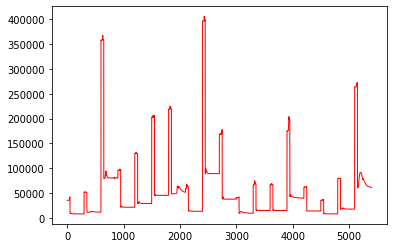

In [25]:
plot_loss(joint_loss)

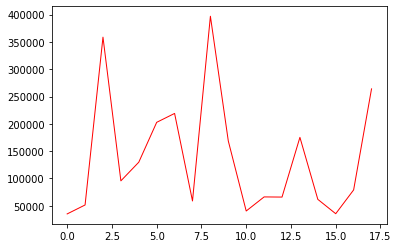

In [26]:
# batch_first
plot_loss(joint_batch_first_loss)

In [31]:
p_1_loss = torch.load("/content/drive/MyDrive/ELI5/out/joint_prob_1.0_ws_5000_js_1500_init_pca_loss.pt").detach().cpu().numpy()
p_1_head_loss = torch.load("/content/drive/MyDrive/ELI5/out/joint_prob_1.0_ws_5000_js_1500_init_pca_batch_first_loss.pt").detach().cpu().numpy()

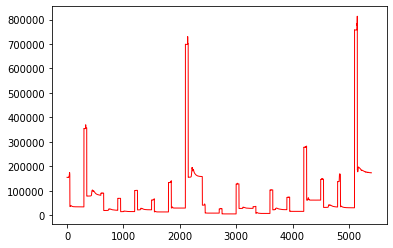

In [32]:
plot_loss(p_1_loss)

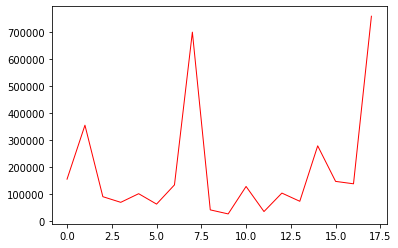

In [34]:
plot_loss(p_1_head_loss)

# Evaluate our results w.r.t IDF recall

load wiki dataset / representations

In [ ]:
!pip install nlp
!pip install apache_beam
!pip install elasticsearch
!pip install faiss_gpu
!pip install transformers

In [5]:
import pickle as pkl
import nlp
import numpy as np
import torch

In [6]:
wiki30k_snippets = pkl.load(open("data/wiki/30k/wiki30k_dataset.pkl","rb"))

In [7]:
wiki30k_snippets.column_names = ['_id', 'article_title', 'end_character', 'end_paragraph', 'nlp_id', 'passage_text', 'section_title', 'start_character', 'start_paragraph', 'wiki_id']

load question texts pairs

In [8]:
with open('data/Questions/20/test_qa_20.pickle', 'rb') as f:
     test_qa_list_20  = pkl.load(f)

Original 128D representation

In [33]:
wiki30k_passage_reps_orig = np.memmap(
            'data/wiki/30k/wiki30k_reps.dat',
            dtype='float32', mode='r',
            shape=(wiki30k_snippets.num_rows, 128)
)

In [52]:
with open('data/Questions/20/q_20_reps.npy', 'rb') as f:
     q_rep_orig  = np.load(f)
q_rep_orig = np.float32(q_rep_orig)

Import from utils file, define idf_recall function

In [9]:
from eval_utils import *

In [81]:
def evaluate(wiki_reps, ques_reps, test_qa_list, d=64):
  faiss_res = faiss.StandardGpuResources()
  wiki30k_index_flat = faiss.IndexFlatIP(d)
  wiki30k_gpu_index = faiss.index_cpu_to_gpu(faiss_res, 0, wiki30k_index_flat)

  def dense_ret_for_eval(q_rep, n_ret):
    _, dense_res_list = query_qa_dense_index(
        q_rep, wiki30k_snippets, wiki30k_gpu_index, n_results=n_ret
    )
    dense_doc = ' '.join([res['passage_text'] for res in dense_res_list])
    return dense_doc,dense_res_list

  # The IDF-recall function is then:
  def da_idf_recall(doc, answer):
    d_words = dict([(w, True) for w in doc.lower().split()])
    a_words = answer.lower().split()   
    recall = sum([1. / math.log(1 + answer_doc_freq.get(w, 1)) for w in a_words if w in d_words]) / \
                sum([1. / math.log(1 + answer_doc_freq.get(w, 1)) for w in a_words])
    return recall
  # load representation

  wiki30k_gpu_index.add(wiki_reps)

  answer_doc_freq = {}
  for q, a in test_qa_list:
    for w in a.lower().split():
        answer_doc_freq[w] = answer_doc_freq.get(w, 0) + 1
  dense_score, all_dense_res_list= evaluate_retriever(test_qa_list, dense_ret_for_eval, da_idf_recall, ques_reps, d=d)
  df = pd.DataFrame({
    'IDF-Recall': [dense_score['idf_recall']],
    'Time/Query': [dense_score['retrieval_time']],
      }, index=['Dense'])
  return df
  

In [74]:
def get_rep(path):
  rep = torch.load(path).detach().cpu().numpy()
  return np.float32(rep)

Original: 0.236188 / 0.008775

In [108]:
df_orig = evaluate(wiki30k_passage_reps_orig, q_rep_orig, test_qa_list_20, d=128)

In [109]:
print(df_orig)

       IDF-Recall  Time/Query
Dense    0.236188    0.008273


In [77]:
def get_joint_path(prob, opt="document"):
  if opt == "document":
    return f"/content/drive/MyDrive/ELI5/out/joint_prob_{prob}_ws_5000_js_1500_init_pca.pt"
  elif opt == "question":
    return f"/content/drive/MyDrive/ELI5/out/joint_prob_{prob}_ws_5000_js_1500_init_pca_question_rep.pt"


In [78]:
w_rep_joint_0_5 = get_rep(get_joint_path(0.5, "document"))
q_rep_joint_0_5 = get_rep(get_joint_path(0.5, "question"))

In [82]:
df_joint_p_0_5 = evaluate(w_rep_joint_0_5, q_rep_joint_0_5,test_qa_list_20, d=64)
#df.style.format({'IDF-Recall': "{:.4f}", 'Time/Query': "{:.4f}"})
#df.to_csv(str(qa_id)+".csv")

joint_fully_fuse: 0.177896 / 0.012033

In [84]:
print(df_joint_p_0_5)

       IDF-Recall  Time/Query
Dense    0.177896    0.012033


In [86]:
w_rep_joint_1_0 = get_rep(get_joint_path(1.0, "document"))
q_rep_joint_1_0 = get_rep(get_joint_path(1.0, "question"))

In [91]:
df_joint_p_0_5 = evaluate(w_rep_joint_1_0, q_rep_joint_1_0, test_qa_list_20, d=64)

joint_half_fuse: 0.181268    0.011258

In [92]:
print(df_joint_p_0_5)

       IDF-Recall  Time/Query
Dense    0.181268    0.011157


Retrieve Path for seperately reduced wiki / questions

In [94]:
def get_sep_path(init, opt="document"):
  if opt == "document":
    return f"/content/drive/MyDrive/ELI5/out/wiki_reduced_only_300_iter/ws_5000_js_1500_init_{init}.pt"
  elif opt == "question":
    return f"/content/drive/MyDrive/ELI5/out/wiki_reduced_only_300_iter/ques20_init_pca.pt"


In [97]:
q_sep = get_rep(get_sep_path("pca", opt="question"))
w_sep_pca = get_rep(get_sep_path("pca"))
w_sep_rand = get_rep(get_sep_path("rand"))

In [107]:
df_sep_pca = evaluate(w_sep_pca, q_sep, test_qa_list_20, d=64)
print(df_sep_pca)

       IDF-Recall  Time/Query
Dense    0.167944    0.004738


In [106]:
df_sep_rand = evaluate(w_sep_rand, q_sep, test_qa_list_20, d=64)
print(df_sep_rand)

       IDF-Recall  Time/Query
Dense    0.188951    0.006725


Simply Truncate!

In [ ]:
w_truncate = wiki30k_passage_reps_orig.T[:64].T #!not continuous
w_truncate = np.asarray(w_truncate, order='C')
q_truncate = np.asarray(q_rep_orig.T[:64].T, order='C')

In [105]:
df_truncate = evaluate(w_truncate, q_truncate, test_qa_list_20, d=64)
print(df_truncate)

       IDF-Recall  Time/Query
Dense    0.240229    0.008331


In [111]:
w_fully_random = np.float32(np.random.rand(len(w_truncate), 64))
q_fully_random = np.float32(np.random.rand(20, 64))
df_full_random = evaluate(w_fully_random, q_fully_random, test_qa_list_20, d=64)
print(df_full_random)

       IDF-Recall  Time/Query
Dense    0.157558    0.009565
